In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.neighbors import KernelDensity  # kernel density estimation
from mpmath import jtheta  # jacobi elliptic theta function
import multiprocessing
from sbpy.data import Names

Import list of all minor planets from the MPC `MPCORB` `.json` file so we can use the same data set as Granvik 2016, 2017, 2018:

Note that the `.json` file needs to be gotten from the MPC for local use.

In [2]:
# list of all minor planets from the MPC:
all_mps = pd.read_json('mpcorb_extended.json')

Read in all the `.csv` files containing all numbered and unnumbered minor planets observed by either `G96` or `703` (CSS) between $2005$ and $2012$. These are generated by processing the `NumObs.txt` and `UnnObs.txt` files from the MPC with the `mpc_process.py` and `mpc_process_unn.py` scripts, respectively.

In [3]:
all_css_num_mpcs = set()
all_css_unn_mpcs = set()

# read in files in a loop
for i in tqdm(range(0, 426)):
    processed_num_csv = pd.read_csv(f'mpc_data/mpc_processed_{i}.csv')
    all_css_num_mpcs.update(processed_num_csv.packed_desig)

for j in tqdm(range(0, 36)):
    processed_unn_csv = pd.read_csv(f'mpc_data_unn/mpc_processed_{j}.csv')
    all_css_unn_mpcs.update(processed_unn_csv.packed_desig)

# convert from packed to unpacked format
unpacked_css_num_mpcs = [Names.from_packed(str(mp)) for mp in list(all_css_num_mpcs)]
unpacked_css_unn_mpcs = [Names.from_packed(str(mp.rstrip('*'))) for mp in list(all_css_unn_mpcs)]  # strip asterisk if it's there

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 58.11it/s]


Get the minor planet number and compute $q$ as $q = a\left(1 - e\right)$:

In [4]:
all_mps['mp_number'] = all_mps.index.astype(int)  # index is the minor planet number
# compute qs
all_mps['q'] = (all_mps.a * (1. - all_mps.e))

Now filter the CSS minor planets using `MPCORB.dat` for $17 < H < 25$ (magnitude limited by Granvik's model) and $q < 1.3$ (NEO).

In [5]:
# first get all numbered or unnumbered minor planets in mpcorb observed by CSS
filtered_mps = all_mps[all_mps.mp_number.isin(unpacked_css_num_mpcs) | all_mps.Principal_desig.isin(unpacked_css_unn_mpcs)]
# then filter by 17 < H < 25 and q < 1.3 to get the final list of NEOs:
mag_limited_neos = filtered_mps[(17. < filtered_mps.H) & (filtered_mps.H < 25.) & (filtered_mps.q < 1.3)]

And get their $q$ values:

In [6]:
mag_limited_qs = mag_limited_neos.q

$2412$ NEOs in the numbered list, adding the unnumbered list gives an additional $3155$ NEOs

Importing the Monte Carlo cloned impactors and computing their $q$ (perihelion distance) values from $a$ and $e$:

In [7]:
orb_param_array_all_events = np.load('orb_params_all_events_mc.npy')  # get the orbital parameters for the clones
orb_param_array_true = np.load('true_impactor_aeis.npy')  # and for the true 14 impactors
orb_param_variables = ['a', 'e', 'i', 'peri', 'node', 'M']  

# get orbital param variables from the numpy files
impactor_as, impactor_es, impactor_is, impactor_peris, impactor_nodes, impactor_Ms = orb_param_array_all_events.T
true_as, true_es, true_is, true_peris, true_nodes, true_Ms = orb_param_array_true.T

# compute q from q = a * (1. - e)
impactor_qs = (impactor_as * (1. - impactor_es))
impactor_qs_flat = impactor_qs.reshape(-1)

Plotting un-weighted normalized histograms for the $q$ values of the cloned impactors and the CSS NEOs:

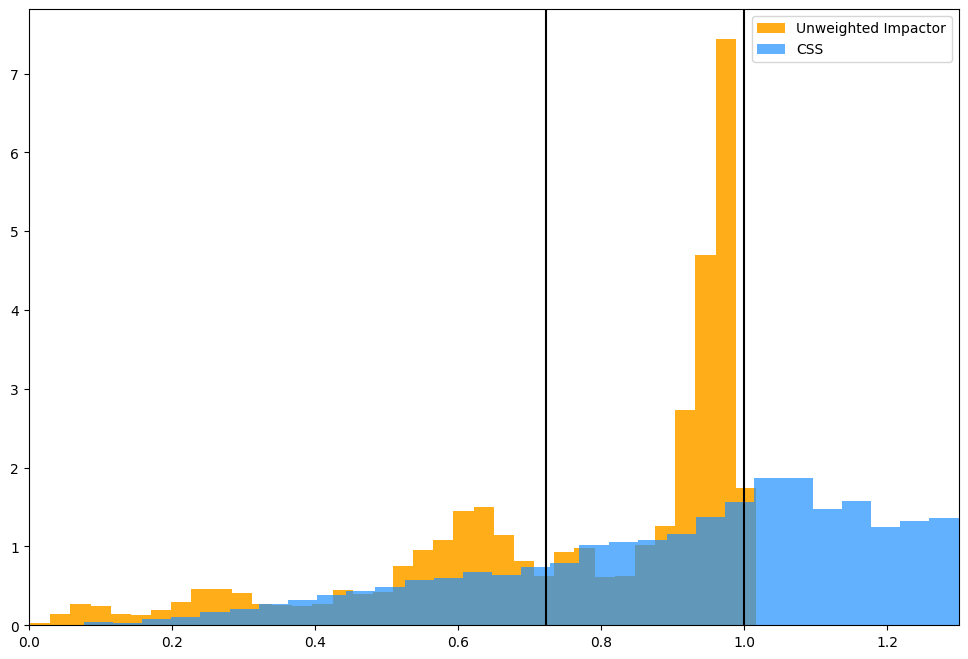

In [8]:
# semi major axes of earth and venus
a_earth = 1.
a_venus = 0.72333199

plt.figure(figsize = (12, 8))
plt.hist(impactor_qs_flat, bins='auto', color = 'orange', label = 'Unweighted Impactor', density=True, alpha=0.9)
plt.hist(mag_limited_qs, bins='auto', color='dodgerblue', label = 'CSS', density=True, alpha=0.7)
# plt.yscale('log')
plt.axvline(a_earth, color = 'k')
plt.axvline(a_venus, color = 'k')
plt.xlim(left=0., right=1.3)
plt.legend()

Compare using a K-S test and find the $p$-value:

In [9]:
import scipy.stats
scipy.stats.ks_2samp(impactor_qs_flat, mag_limited_qs).pvalue

0.0

Now compute weights for each of the impactors from their Opik impact probability, given $a$, $e$ and $i$:

Use the same function for collision probability per revolution in the `monte_carlo_granvik_model.ipynb` notebook:

In [10]:
# constants for earth and sun
a0 = 1.  # semi-major axis of earth in au
m = 5.97e24  # mass of earth in kg
R = 4.259e-5  # radius of earth in au
M = 1.988e30  # mass of sun in kg

# get the probability per revolution P
def get_P(a, e, i, a0=a0, m=m, R=R, M=M):
    """
    Get the collision probability per revolution P for an object with semi-major axis a in AU, eccentricity e, and inclination i in degrees
    and a target on a circular orbit with constant semi-major axis a0 in AU, mass m in kg, and radius R in AU, 
    both orbiting a star with mass M in kg

    return: P, the collision probability per revolution
    """
    Q = R/a0  # Q
    Ux = np.sqrt(2 - (1/a) - (a * (1 - (e ** 2))))  # Ux
    U = np.sqrt(3 - (1/a) - ((2 * np.sqrt(a * (1 - e ** 2))) * np.cos(np.deg2rad(i))))  # U
    tau = Q * np.sqrt(1 + ((2 * m)/(M * Q * (U ** 2))))  # tau
    # tau = R * np.sqrt(1 + R/Q)
    # compute P
    P = ((tau ** 2) * U)/(np.pi * np.sin(np.deg2rad(i)) * np.abs(Ux))
    # return
    return P

Convert the impact probability per revolution $P$ into an impact probability per year $P_t$:

In [11]:
impactor_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(impactor_as, impactor_es, impactor_is)])
true_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(true_as, true_es, true_is)])

impactor_pts_flat = impactor_pts.reshape(-1)

/tmp/ipykernel_222943/1632827845.py:17: RuntimeWarning: invalid value encountered in sqrt
  Ux = np.sqrt(2 - (1/a) - (a * (1 - (e ** 2))))  # Ux
/tmp/ipykernel_222943/3580413378.py:1: RuntimeWarning: invalid value encountered in power
  impactor_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(impactor_as, impactor_es, impactor_is)])
/tmp/ipykernel_222943/1632827845.py:18: RuntimeWarning: invalid value encountered in sqrt
  U = np.sqrt(3 - (1/a) - ((2 * np.sqrt(a * (1 - e ** 2))) * np.cos(np.deg2rad(i))))  # U


Plot a histogram of the $\log_{10}$ annual impact probability:

(Text(0.5, 0, '$\\log_{10}\\,$impact probability per year'),
 Text(0, 0.5, 'Density'))

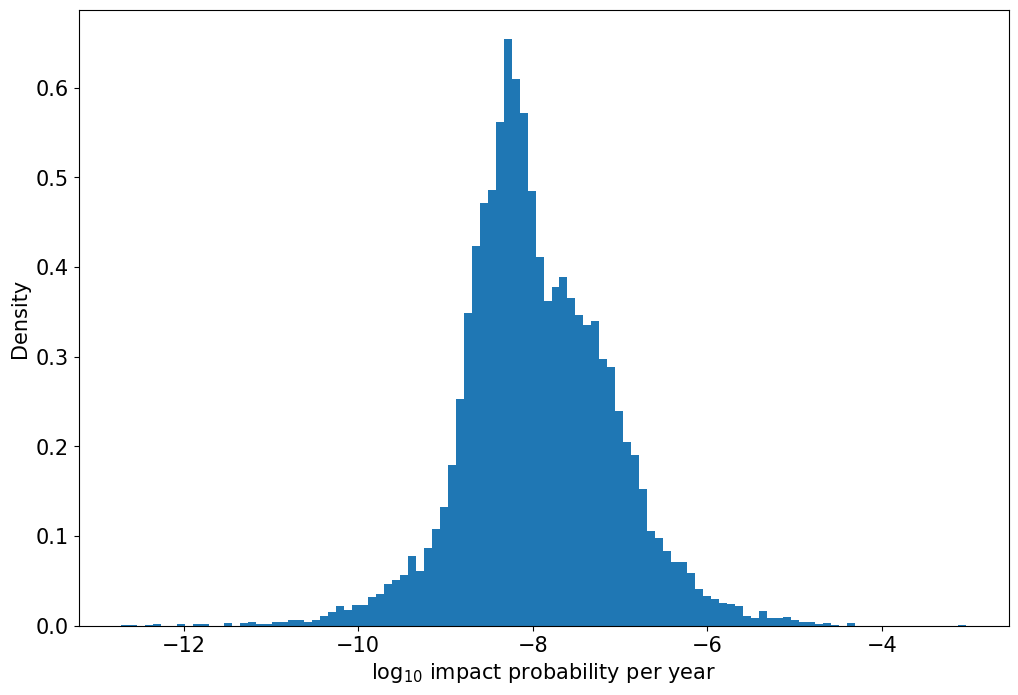

In [12]:
plt.rc('font', size=15)
# convert to lgo to make more readable
plt.figure(figsize = (12, 8))
# plot histogram
plt.hist(np.log10(impactor_pts_flat), bins='auto', density=True)
# label axes
plt.xlabel(r'$\log_{10}\,$impact probability per year'), plt.ylabel('Density')

Eliminate all clones with `nan` annual impact probabilities:

In [13]:
non_nan_mask = ~np.isnan(impactor_pts_flat)  # mask of all non-nan impact probabilities
# filter out nan impact probabilities
impactor_pts_flat_filtered = impactor_pts_flat[non_nan_mask]
impactor_qs_flat_filtered = impactor_qs_flat[non_nan_mask]

# filter out points with too high impact probability (say above 1e-4)
high_impact_prob_mask = impactor_pts_flat_filtered < 1e-4
# impactor_pts_flat_filtered = impactor_pts_flat_filtered[high_impact_prob_mask]
# impactor_qs_flat_filtered = impactor_qs_flat_filtered[high_impact_prob_mask]

(Text(0.5, 0, 'Annual impact probability'), Text(0, 0.5, 'q'))

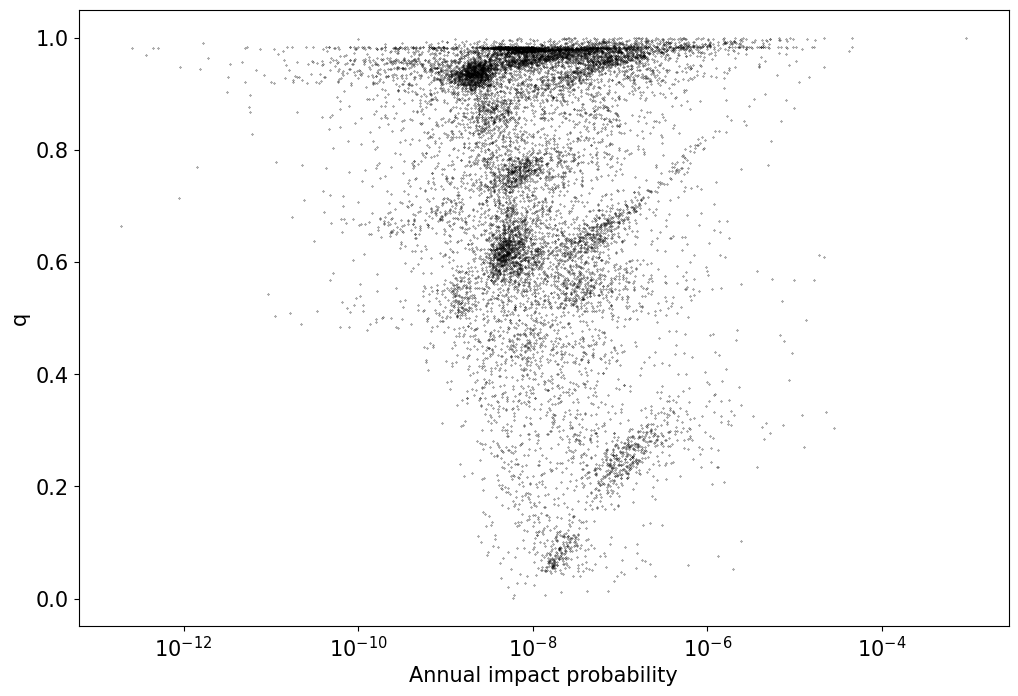

In [14]:
plt.figure(figsize = (12, 8))
plt.scatter(impactor_pts_flat_filtered, impactor_qs_flat_filtered, s=0.07, c='k')
plt.xscale('log')
plt.xlabel('Annual impact probability'), plt.ylabel('q')

Then plot a histogram comparing the weighted and unweighted $q$ values for the cloned impactors as well as a histogram of the $q$ values for the cloned impactors, weighting by impact probability:

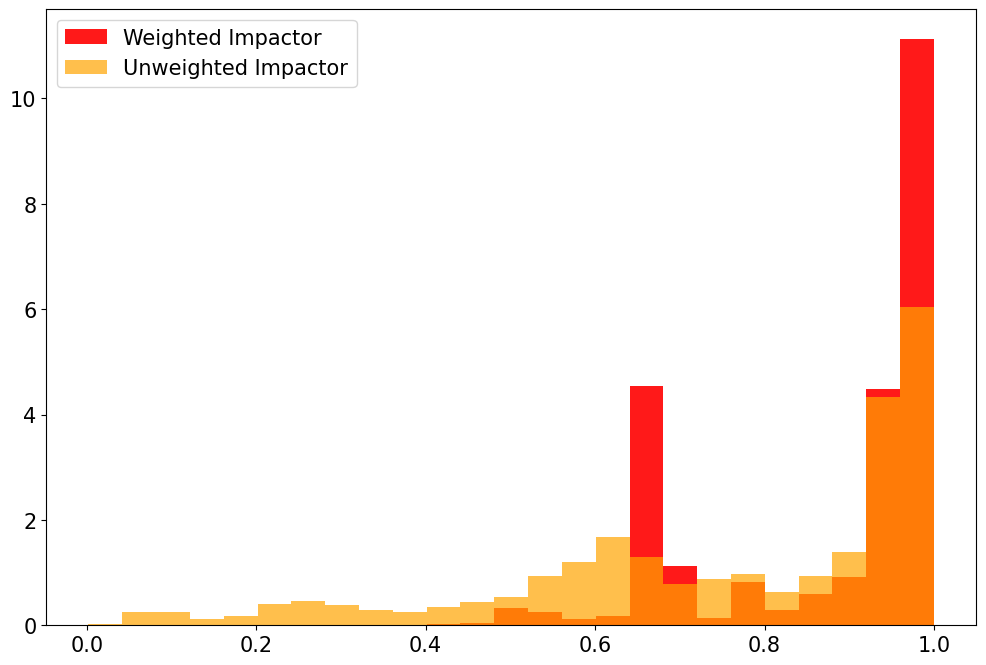

In [15]:
plt.figure(figsize = (12, 8))
plt.hist(impactor_qs_flat_filtered, bins=25, color = 'red', label = 'Weighted Impactor', density=True, 
         weights=1./impactor_pts_flat_filtered, alpha=0.9)
plt.hist(impactor_qs_flat_filtered, bins=25, color = 'orange', label = 'Unweighted Impactor', density=True, 
         weights=None, alpha=0.7)
# plt.yscale('log')
plt.legend()

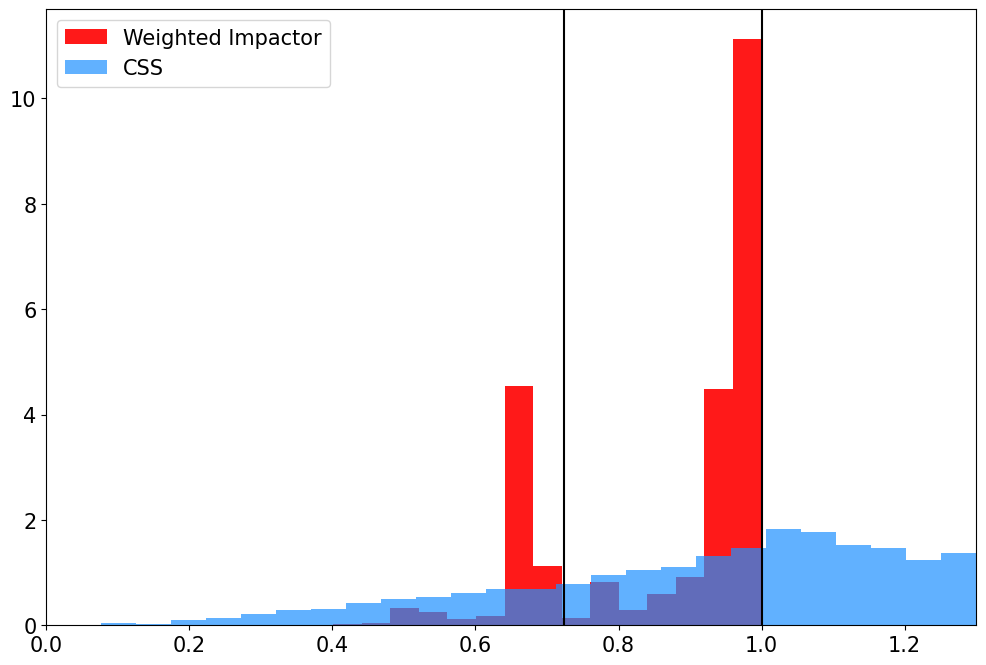

In [16]:
# semi major axes of earth and venus
a_earth = 1.
a_venus = 0.72333199

plt.figure(figsize = (12, 8))
plt.hist(impactor_qs_flat_filtered, bins=25, color = 'red', label = 'Weighted Impactor', density=True, 
         weights=1./impactor_pts_flat_filtered, alpha=0.9)
plt.hist(mag_limited_qs, bins=25, color='dodgerblue', label = 'CSS', density=True, 
         weights=None, alpha=0.7)
# plt.yscale('log')
plt.axvline(a_earth, color = 'k')
plt.axvline(a_venus, color = 'k')
plt.xlim(left=0., right=1.3)
plt.legend()

Weighted K-S test:

In [17]:
from scipy.stats import distributions

def ks_weighted(data1, data2, wei1, wei2, alternative='two-sided'):
    ix1 = np.argsort(data1)
    ix2 = np.argsort(data2)
    data1 = data1[ix1]
    data2 = data2[ix2]
    wei1 = wei1[ix1]
    wei2 = wei2[ix2]
    data = np.concatenate([data1, data2])
    cwei1 = np.hstack([0, np.cumsum(wei1)/sum(wei1)])
    cwei2 = np.hstack([0, np.cumsum(wei2)/sum(wei2)])
    cdf1we = cwei1[np.searchsorted(data1, data, side='right')]
    cdf2we = cwei2[np.searchsorted(data2, data, side='right')]
    d = np.max(np.abs(cdf1we - cdf2we))
    # calculate p-value
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    m, n = sorted([float(n1), float(n2)], reverse=True)
    en = m * n / (m + n)
    if alternative == 'two-sided':
        prob = distributions.kstwo.sf(d, np.round(en))
    else:
        z = np.sqrt(en) * d
        # Use Hodges' suggested approximation Eqn 5.3
        # Requires m to be the larger of (n1, n2)
        expt = -2 * z**2 - 2 * z * (m + 2*n)/np.sqrt(m*n*(m+n))/3.0
        prob = np.exp(expt)
    return d, prob

Computing 1-D K-S test for unweighted and weighted $q$ values and compare unweighted result to default `scipy` K-S test implementation:

In [18]:
print('Unweighted:', ks_weighted(impactor_qs_flat_filtered, np.array(mag_limited_qs), 
                  np.ones(len(impactor_qs_flat_filtered)), np.ones(len(np.array(mag_limited_qs))))) 
print('Weighted:', ks_weighted(impactor_qs_flat_filtered, np.array(mag_limited_qs), 
                  1./impactor_pts_flat_filtered, np.ones(len(np.array(mag_limited_qs)))))

Unweighted: (0.4626766779072764, 0.0)
Weighted: (0.47705555460824267, 0.0)


In [19]:
scipy.stats.ks_2samp(impactor_qs_flat_filtered, mag_limited_qs).statistic, scipy.stats.ks_2samp(impactor_qs_flat_filtered, mag_limited_qs).pvalue

(0.4626766779072764, 0.0)

### Comparing to 824 EN fireballs and the EMCCD Meteors:

Read in the $824$ EN fireballs from Borovicka et al. 2022

In [20]:
en_fireballs = pd.read_fwf('catalog.dat', header=None).drop(columns=[81, 85]) # drop column 81 as well since it's having trouble reading phaethon
en_fireballs.columns = ['code', 'obs_date', 'obs_time', 'e_obs_time', 'jd', 
                        'lsun', 'lam-beg', 'phi-beg', 'h-beg', 'lam-end', 
                        'phi-end', 'h-end', 'lam-avg', 'phi-avg', 'h-avg', 
                        'lam-max', 'phi-max', 'h-max', 'length', 'dur', 
                        'azim', 'zendis', 'radeg', 'e_radeg', 'dedeg', 
                        'e_dedeg', 'vinf', 'e_vinf', 'vmax', 'vter', 
                        'hvter', 'rageo', 'e_rageo', 'degeo', 'e_degeo', 
                        'lgeo-lsun', 'bgeo', 'vgeo', 'e_vgeo', 'lhel', 
                        'e_lhel', 'bhel', 'e_bhel', 'vhel', 'e_vhel', 
                        'ax', 'e_ax', 'ecc', 'e_ecc', 'perih', 
                        'e_perih', 'aph', 'e_aph', 'inc', 'e_inc', 
                        'omg', 'e_omg', 'nod', 'e_nod', 'lper', 
                        'e_lper', 'tyear', 'tmonth', 'tday', 'e_tday', 
                        'per', 'e_per', 'tiss', 'e_tiss', 'mag', 
                        'energy', 'mass', 'termass', 'pe', 'type', 
                        'pres', 'hpres', 'pf', 'pf-class', 'shower', 
                        'object', 'ncam', 'mindist', 'spectrum']

Read in the EMCCD data:

In [21]:
# import kb_and_kc_calc
# emccd_meteors = kb_and_kc_calc.extract_from_table()

emccd_meteors = pd.read_json('solution_table.json')

Perform the same impact probability weighting for the EN fireballs and the EMCCD data:

In [22]:
# get a, e, i, q for en fireballs
en_as, en_es, en_is, en_qs = np.array(en_fireballs[['ax', 'ecc', 'inc', 'perih']]).T
emccd_as, emccd_es, emccd_is, emccd_qs = np.array(emccd_meteors[['a', 'e', 'i', 'q']]).T

# and get the EN annual impact probabilities
en_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(en_as, en_es, en_is)])
emccd_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(emccd_as, emccd_es, emccd_is)])

/tmp/ipykernel_222943/409780143.py:6: RuntimeWarning: invalid value encountered in scalar power
  en_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(en_as, en_es, en_is)])
/tmp/ipykernel_222943/1632827845.py:17: RuntimeWarning: invalid value encountered in sqrt
  Ux = np.sqrt(2 - (1/a) - (a * (1 - (e ** 2))))  # Ux
/tmp/ipykernel_222943/409780143.py:7: RuntimeWarning: invalid value encountered in scalar power
  emccd_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(emccd_as, emccd_es, emccd_is)])


Plot probabilities:

In [23]:
i = 0
en_as[i] * (1. - (en_es[i])), en_as[i], en_es[i], en_is[i], en_qs[i]

(0.9653027999999986, 28.644, 0.9663, 113.08, 0.9656)

In [24]:
emccd_as[i] * (1. - (emccd_es[i])), emccd_as[i], emccd_es[i], emccd_is[i], emccd_qs[i]

(0.6434241307398988,
 -35.889931895722974,
 1.017927705536175,
 22.999065868470193,
 0.643424130739914)

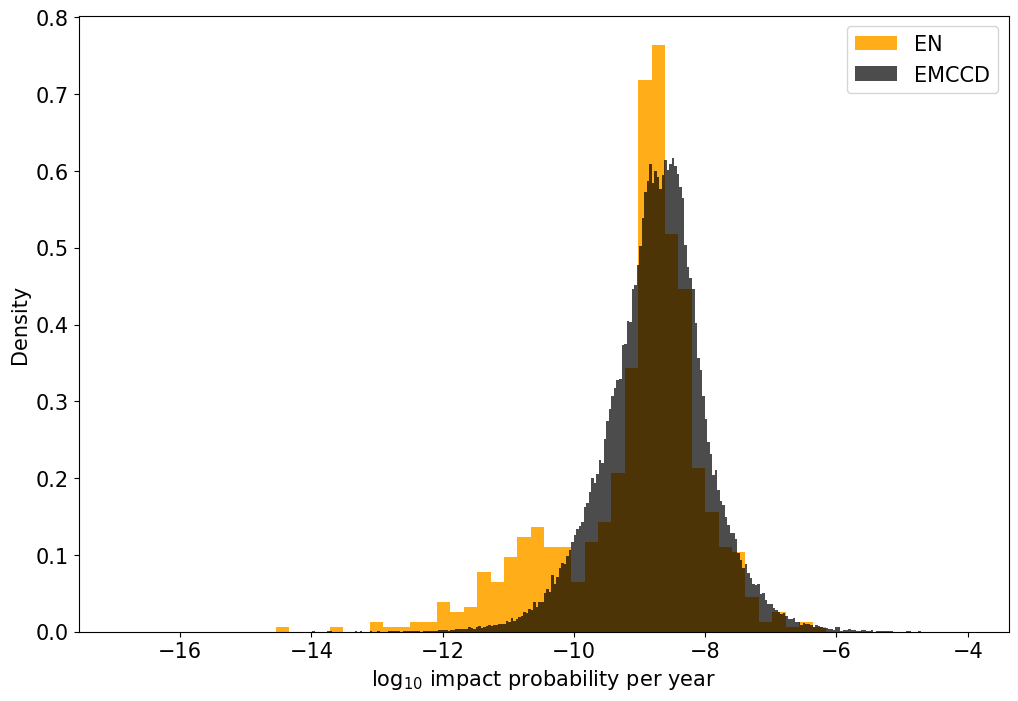

In [25]:
plt.rc('font', size=15)
# convert to lgo to make more readable
plt.figure(figsize = (12, 8))
# plot histogram
plt.hist(np.log10(en_pts), bins='auto', density=True, label = 'EN', color='orange', alpha=0.9)
plt.hist(np.log10(emccd_pts), bins='auto', density=True, label = 'EMCCD', color='black', alpha=0.7)
# label axes
plt.xlabel(r'$\log_{10}\,$impact probability per year'), plt.ylabel('Density')
plt.legend()

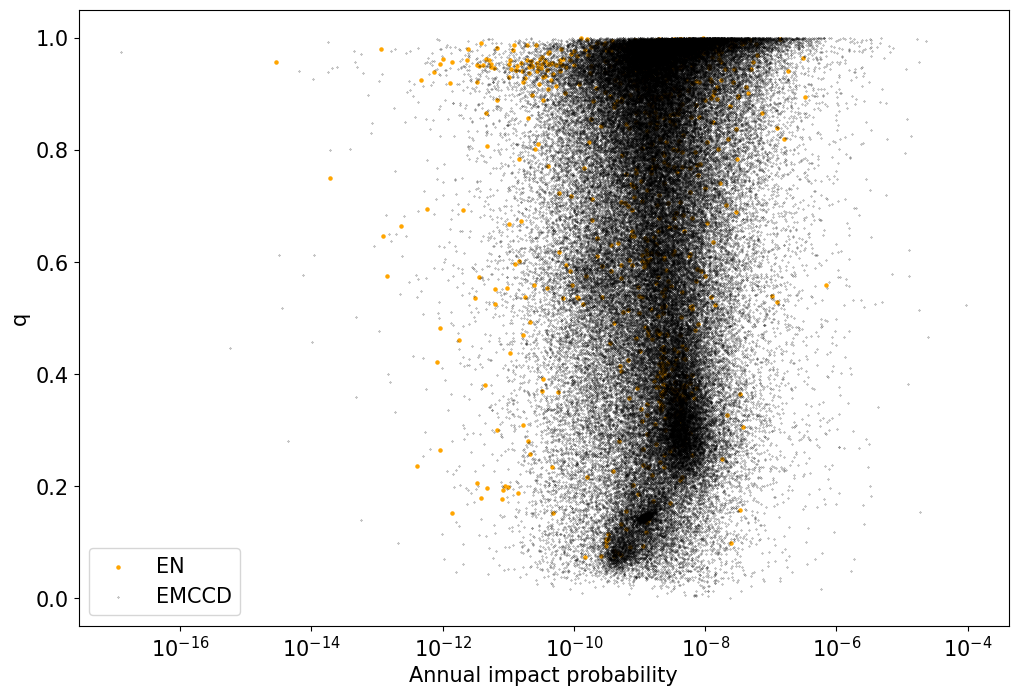

In [26]:
plt.figure(figsize = (12, 8))
plt.scatter(en_pts, en_qs, s=5, c='orange', label = 'EN')
plt.scatter(emccd_pts, emccd_qs, s=0.07, c='black', label = 'EMCCD', alpha=0.7)
plt.xscale('log')
plt.xlabel('Annual impact probability'), plt.ylabel('q')
plt.legend()

Filter `nan`s:

In [27]:
en_non_nan_mask = ~np.isnan(en_pts)  # mask of all non-nan impact probabilities
emccd_non_nan_mask = ~np.isnan(emccd_pts)

# filter out nan impact probabilities
en_pts_filtered = en_pts[en_non_nan_mask]
en_qs_filtered = en_qs[en_non_nan_mask]

emccd_pts_filtered = emccd_pts[emccd_non_nan_mask]
emccd_qs_filtered = emccd_qs[emccd_non_nan_mask]

And plot a histogram of the CSS observations against the weighted decameter impactors, weighted EN fireballs and the weighted EMCCD meteors:

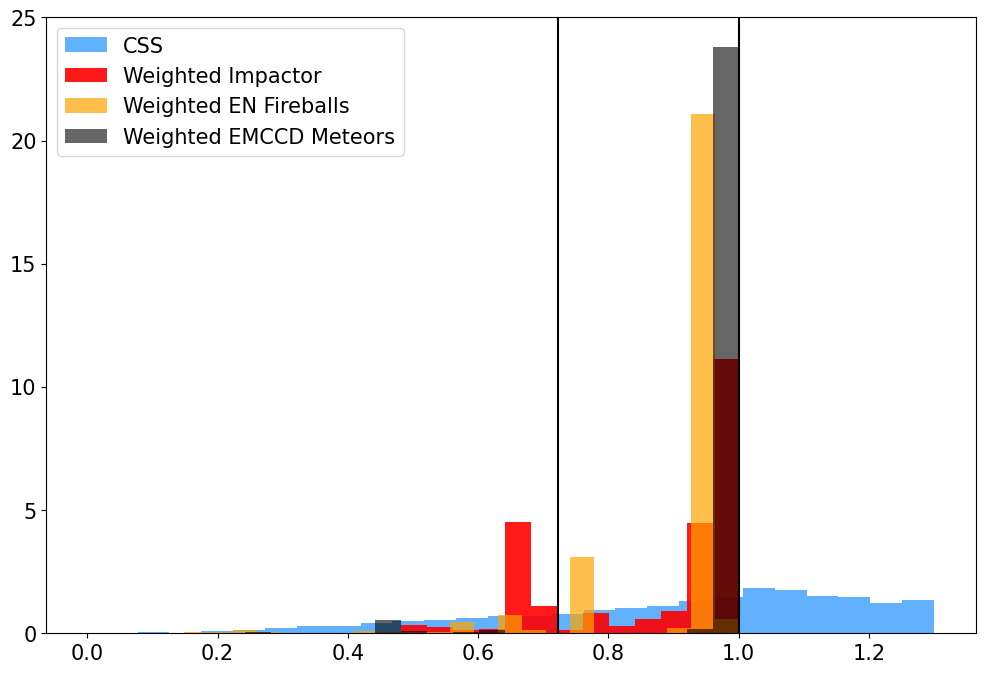

In [28]:
plt.figure(figsize = (12, 8))
plt.hist(mag_limited_qs, bins=25, color='dodgerblue', label = 'CSS', density=True, 
         weights=None, alpha=0.7)
plt.hist(impactor_qs_flat_filtered, bins=25, color = 'red', label = 'Weighted Impactor', density=True, 
         weights=1./impactor_pts_flat_filtered, alpha=0.9)
# plt.hist(en_qs[en_non_nan_mask], bins=25, color='green', label = 'Unweighted EN Fireballs', density=True, alpha=0.7)
plt.hist(en_qs_filtered, bins=25, color = 'orange', label = 'Weighted EN Fireballs', density=True, 
         weights=1./en_pts_filtered, alpha=0.7)
# plt.hist(emccd_qs[emccd_non_nan_mask], bins=25, color='green', label = 'Unweighted EMCCD Meteors', density=True)
plt.hist(emccd_qs_filtered, bins=25, color = 'black', label = 'Weighted EMCCD Meteors', density=True, 
         weights=1./emccd_pts_filtered, alpha=0.6)

# plt.yscale('log')
plt.legend()
plt.axvline(a_earth, color = 'k')
plt.axvline(a_venus, color = 'k')